In [1]:
from shapely.geometry import box, Point, LineString
import pyrosm
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
import geopandas
import pandas as pd
import numpy as np
import networkx as nx
import math
from rasterio.crs import CRS
from sys import getsizeof

/mnt/c/Users/Alfred/CLionProjects/outbreak-sim/python/venv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 2000
OUT_CRS = CRS.from_epsg(27700)  # https://epsg.io/27700

In [3]:
# convenience function for printing
def print_size(obj, suffix='B'):
    num = getsizeof(obj)
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    print("%.1f%s%s" % (num, 'Yi', suffix))

In [4]:
%%time
import pickle
from pathlib import Path

class Person():
    def __init__(self, uid, household_uid, age, pos):
        self.uid = uid
        self.household_uid = household_uid
        self.age = age
        self.pos = pos
    
households_gdf = pickle.loads(Path('pickles/south_london/households_gdf').read_bytes())
people = pickle.loads(Path('pickles/south_london/people_list').read_bytes())
trimmed_work = pickle.loads(Path('pickles/south_london/workplaces_gdf').read_bytes())
boundary = pickle.loads(Path('pickles/south_london/boundary').read_bytes())

CPU times: user 7.44 s, sys: 1.31 s, total: 8.75 s
Wall time: 8.75 s


<AxesSubplot:>

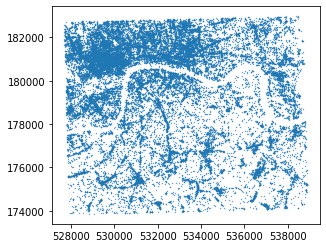

In [5]:
trimmed_work.plot(markersize=0.1)

In [6]:
%%time
# get all public transport
full_edges = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/edges.csv')
full_nodes = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/nodes.csv')
full_nodes = geopandas.GeoDataFrame(full_nodes, geometry=geopandas.points_from_xy(full_nodes.lon, full_nodes.lat), crs="EPSG:4326")
layers = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/layers.csv')

# Clip the nodes to the boundary
nodes = geopandas.clip(full_nodes, boundary)
# Only select edges that start or end at the clipped nodes
des_edges = full_edges[full_edges.rename(columns={'des_node': 'node', 'des_layer': 'layer'}).set_index(['node', 'layer']).index.isin(nodes.set_index(['node', 'layer']).index)]
ori_edges = full_edges[full_edges.rename(columns={'ori_node': 'node', 'ori_layer': 'layer'}).set_index(['node', 'layer']).index.isin(nodes.set_index(['node', 'layer']).index)]
unclipped_edges = des_edges.merge(ori_edges) # inner merge to get edges that start and end in the boundary

CPU times: user 3.09 s, sys: 234 ms, total: 3.33 s
Wall time: 3.35 s


In [7]:
%%time
# Draw lines for the edges
old_index = full_nodes.index
full_nodes = full_nodes.set_index(['node', 'layer'])
unclipped_edges = geopandas.GeoDataFrame(unclipped_edges, geometry=unclipped_edges.apply(lambda x: LineString([
    full_nodes.loc[(x.ori_node, x.ori_layer)].geometry, 
    full_nodes.loc[(x.des_node, x.des_layer)].geometry
]), axis=1))
full_nodes = full_nodes.reset_index()
full_nodes.index = old_index

# commented for now as we require des AND ori nodes to be within the boundary instead of OR
# Clip those edges to the boundary too
# edges = geopandas.clip(unclipped_edges.reset_index(), boundary)  
# Get rid of empty geometries
#edges = edges[~edges.is_empty]
edges = unclipped_edges

CPU times: user 1.7 s, sys: 0 ns, total: 1.7 s
Wall time: 1.7 s


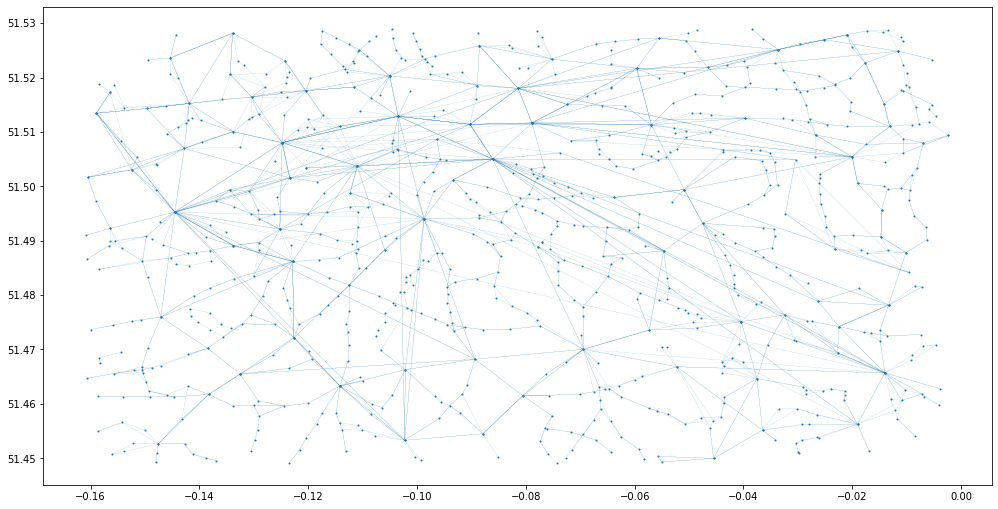

In [8]:
fig, ax = plt.subplots(figsize=(17, 17))
nodes.plot(ax=ax, markersize=1)
edges.plot(ax=ax, linewidth=0.1)
del fig, ax

In [9]:
nodes['osmid'] = nodes['node'].astype(str) + '_' + nodes['layer'].astype(str)
nodes['x'] = nodes.geometry.x
nodes['y'] = nodes.geometry.y
nodes.set_index('osmid', verify_integrity=True, inplace=True, drop=False) # keep the column as osmnx needs it (as well as it being the index of the DF)
nodes

,node,layer,lat,lon,zone,atcocode,geometry,osmid,x,y
osmid,,,,,,,,,,
20_5,20,5,51.45774,-0.12900,490,490G00009460,POINT (-0.12900 51.45774),20_5,-0.12900,51.45774
154_5,154,5,51.48817,-0.13813,490,490G00011004,POINT (-0.13813 51.48817),154_5,-0.13813,51.48817
259_5,259,5,51.51741,-0.12497,490,490G00010131,POINT (-0.12497 51.51741),259_5,-0.12497,51.51741
269_5,269,5,51.47554,-0.09672,490,490G00011846,POINT (-0.09672 51.47554),269_5,-0.09672,51.47554
335_5,335,5,51.46630,-0.10218,490,910GLBGHJN,POINT (-0.10218 51.46630),335_5,-0.10218,51.46630
...,...,...,...,...,...,...,...,...,...,...
260225_5,260225,5,51.47163,-0.03038,490,490009530S,POINT (-0.03038 51.47163),260225_5,-0.03038,51.47163
260275_5,260275,5,51.47299,-0.01661,490,490007514W,POINT (-0.01661 51.47299),260275_5,-0.01661,51.47299
262188_5,262188,5,51.51883,-0.15843,490,490009990N,POINT (-0.15843 51.51883),262188_5,-0.15843,51.51883


In [10]:
edges['u'] = edges['ori_node'].astype(str) + '_' + edges['ori_layer'].astype(str)
edges['v'] = edges['des_node'].astype(str) + '_' + edges['des_layer'].astype(str)
edges['key'] = edges.reset_index()['index']
edges['osmid'] = edges['u'].astype(str) + '_' + edges['v'].astype(str)
edges.set_index(['u', 'v', 'key'], inplace=True)
edges = edges.set_crs("EPSG:4326")
edges

ori_node  des_node  ori_layer  des_layer  minutes  \
u       v       key                                                       
7351_1  25717_1 0         7351     25717          1          1       14   
13745_1 35082_1 1        13745     35082          1          1        5   
        35743_1 2        13745     35743          1          1        5   
25717_1 7351_1  3        25717      7351          1          1       14   
        35082_1 4        25717     35082          1          1        4   
...                        ...       ...        ...        ...      ...   
50899_3 50899_5 2465     50899     50899          3          5        2   
51076_5 51076_1 2466     51076     51076          5          1        4   
51076_1 51076_5 2467     51076     51076          1          5        4   
94175_4 94175_5 2468     94175     94175          4          5        1   
94175_5 94175_4 2469     94175     94175          5          4        1   

                         km  \
u       v       key           
7351_1  25717_1 0     2.710   
13745_1 35082_1 1     1.483   
        35743_1 2     1.569   
25717_1 7351_1  3     2.710   
        35082_1 4     0.814   
...                     ...   
50899_3 50899_5 2465  0.155   
51076_5 51076_1 2466  0.251   
51076_1 51076_5 2467  0.251   
94175_4 94175_5 2468  0.000   
94175_5 94175_4 2469  0.000   

                                                               geometry  \
u       v       key                                                       
7351_1  25717_1 0     LINESTRING (-0.12523 51.49212, -0.09635 51.50863)   
13745_1 35082_1 1     LINESTRING (-0.10346 51.51287, -0.08609 51.50502)   
        35743_1 2     LINESTRING (-0.10346 51.51287, -0.12480 51.50803)   
25717_1 7351_1  3     LINESTRING (-0.09635 51.50863, -0.12523 51.49212)   
        35082_1 4     LINESTRING (-0.09635 51.50863, -0.08609 51.50502)   
...                                                                 ...   
50899_3 50899_5 2465  LINESTRING (-0.06376 51.49796, -0.06376 51.49796)   
51076_5 51076_1 2466  LINESTRING (-0.12038 51.50342, -0.12038 51.50342)   
51076_1 51076_5 2467  LINESTRING (-0.12038 51.50342, -0.12038 51.50342)   
94175_4 94175_5 2468  LINESTRING (-0.07712 51.48971, -0.07712 51.48971)   
94175_5 94175_4 2469  LINESTRING (-0.07712 51.48971, -0.07712 51.48971)   

                                osmid  
u       v       key                    
7351_1  25717_1 0      7351_1_25717_1  
13745_1 35082_1 1     13745_1_35082_1  
        35743_1 2     13745_1_35743_1  
25717_1 7351_1  3      25717_1_7351_1  
        35082_1 4     25717_1_35082_1  
...                               ...  
50899_3 50899_5 2465  50899_3_50899_5  
51076_5 51076_1 2466  51076_5_51076_1  
51076_1 51076_5 2467  51076_1_51076_5  
94175_4 94175_5 2468  94175_4_94175_5  
94175_5 94175_4 2469  94175_5_94175_4  

[2470 rows x 8 columns]

In [11]:
import osmnx
graph = osmnx.utils_graph.graph_from_gdfs(nodes, edges, None)

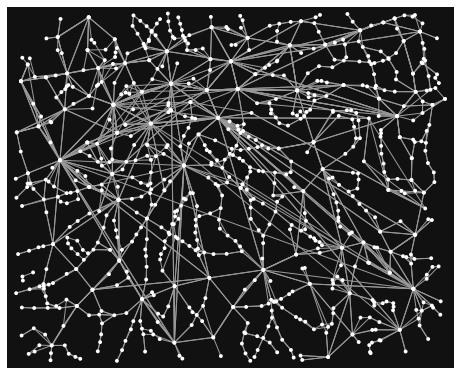

In [12]:
fig, ax = osmnx.plot_graph(graph)

In [13]:
osmnx.utils_graph.graph_to_gdfs(graph, nodes=False)

ori_node  des_node  ori_layer  des_layer  minutes  \
u        v        key                                                       
7351_1   25717_1  0         7351     25717          1          1       14   
         7351_4   2121      7351      7351          1          4        2   
         7351_5   2123      7351      7351          1          5        3   
25717_1  7351_1   3        25717      7351          1          1       14   
         35082_1  4        25717     35082          1          1        4   
...                          ...       ...        ...        ...      ...   
252358_5 120808_5 2056    252358    120808          5          5        1   
252643_5 811_5    2058    252643       811          5          5        1   
262344_5 252358_5 2071    262344    252358          5          5        1   
35458_2  35458_5  2355     35458     35458          2          5        4   
         35458_3  2358     35458     35458          2          3        4   

                           km  \
u        v        key           
7351_1   25717_1  0     2.710   
         7351_4   2121  0.161   
         7351_5   2123  0.188   
25717_1  7351_1   3     2.710   
         35082_1  4     0.814   
...                       ...   
252358_5 120808_5 2056  0.216   
252643_5 811_5    2058  0.436   
262344_5 252358_5 2071  0.153   
35458_2  35458_5  2355  0.329   
         35458_3  2358  0.273   

                                                                 geometry  \
u        v        key                                                       
7351_1   25717_1  0     LINESTRING (-0.12523 51.49212, -0.09635 51.50863)   
         7351_4   2121  LINESTRING (-0.12523 51.49212, -0.12523 51.49212)   
         7351_5   2123  LINESTRING (-0.12523 51.49212, -0.12523 51.49212)   
25717_1  7351_1   3     LINESTRING (-0.09635 51.50863, -0.12523 51.49212)   
         35082_1  4     LINESTRING (-0.09635 51.50863, -0.08609 51.50502)   
...                                                                   ...   
252358_5 120808_5 2056  LINESTRING (-0.14031 51.47499, -0.13800 51.47367)   
252643_5 811_5    2058  LINESTRING (-0.05501 51.47037, -0.05227 51.46683)   
262344_5 252358_5 2071  LINESTRING (-0.14156 51.47613, -0.14031 51.47499)   
35458_2  35458_5  2355  LINESTRING (-0.13392 51.52814, -0.13392 51.52814)   
         35458_3  2358  LINESTRING (-0.13392 51.52814, -0.13392 51.52814)   

                                    osmid  
u        v        key                      
7351_1   25717_1  0        7351_1_25717_1  
         7351_4   2121      7351_1_7351_4  
         7351_5   2123      7351_1_7351_5  
25717_1  7351_1   3        25717_1_7351_1  
         35082_1  4       25717_1_35082_1  
...                                   ...  
252358_5 120808_5 2056  252358_5_120808_5  
252643_5 811_5    2058     252643_5_811_5  
262344_5 252358_5 2071  262344_5_252358_5  
35458_2  35458_5  2355    35458_2_35458_5  
         35458_3  2358    35458_2_35458_3  

[2470 rows x 8 columns]

In [14]:
%%time
transit_node_positions = [tuple(coord) for coord in nodes[['x', 'y']].to_numpy()]
nodeKdTree = cKDTree(data=transit_node_positions)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.6 ms


In [15]:
# TODO delete when new pickles are made
for person in people:
    person.pos = (person.pos.x, person.pos.y)

In [16]:
# %%time
# amount = 10_000
# print(f'For {amount} iterations')
# for index, person in enumerate(people):
#     if index > amount:
#         break
#     osmnx.distance.get_nearest_node(graph, person.pos)

In [17]:
# %%time
# print(f'For {len(people)} iterations')
# for index, person in enumerate(people):
#     nodeKdTree.query(x=person.pos, k=1)

In [18]:
# inspired by https://gis.stackexchange.com/a/301935
def cKDQueryRadius(gdA_in, gdB_in, radius=300, reproject=True, p=2.0, workers=1):
    gdA = gdA_in.copy()
    gdB = gdB_in.copy()
    if reproject:
        in_crs = gdA.crs
        gdA = gdA.to_crs(OUT_CRS)
        gdB = gdB.to_crs(OUT_CRS)
        
    nA = np.array(list(gdA.geometry.centroid.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.centroid.apply(lambda x: (x.x, x.y))))
    
    btree = cKDTree(nB)
    elements_in_radius = btree.query_ball_point(nA, r=radius, p=p, workers=workers)

    gdf = pd.concat(
        [gdA.reset_index(drop=True),
        pd.Series(elements_in_radius, name='Elements in Radius')], axis=1
    )
    if reproject:
        gdf = gdf.to_crs(gdA_in.crs)
    return gdf

In [19]:
%%time
work_nearest_nodes = cKDQueryRadius(trimmed_work, nodes, radius=1_500, workers=5)
print_size(work_nearest_nodes)

CPU times: user 4.67 s, sys: 250 ms, total: 4.92 s
Wall time: 4.68 s


'21.6MiB'

In [20]:
%%time
nodes_nearest_households = cKDQueryRadius(nodes, households_gdf, radius=1_500, workers=5)
print_size(nodes_nearest_households)

CPU times: user 55.2 s, sys: 2.81 s, total: 58 s
Wall time: 56.2 s


'256.6MiB'

In [21]:
%%time
len_path = dict(nx.all_pairs_dijkstra(graph, cutoff=90, weight='minutes'))  # {node_num: ( {target_num: dist_num}, {target_num: [...path_elements]} ) }

CPU times: user 4.89 s, sys: 312 ms, total: 5.2 s
Wall time: 5.22 s


In [22]:
%%time
household_positions = list(households_gdf.geometry.centroid.apply(lambda x: (x.x, x.y)))
households_kd_tree = cKDTree(data=household_positions)
# print_size(households_kd_tree) doesn't work

CPU times: user 53.9 s, sys: 1.22 s, total: 55.1 s
Wall time: 55.2 s


In [23]:
%%time
workplace_positions = [(x, y) for x, y in zip(trimmed_work.geometry.x, trimmed_work.geometry.y)]

CPU times: user 46.9 ms, sys: 15.6 ms, total: 62.5 ms
Wall time: 43.2 ms


In [24]:
%%time
for pos in workplace_positions:
    households_kd_tree.query_ball_point(pos, 500)

CPU times: user 5.86 s, sys: 15.6 ms, total: 5.88 s
Wall time: 5.85 s


In [25]:
households_gdf

,uid,inhabitants,geometry
0,0,3,POINT (528321.877 182711.925)
1,1,2,POINT (528106.593 182646.838)
2,2,3,POINT (528489.985 182698.677)
3,3,2,POINT (528278.628 182694.736)
4,4,3,POINT (528506.105 182704.682)
...,...,...,...
589971,589971,2,POINT (538764.344 174282.348)
589972,589972,2,POINT (538815.190 174343.419)
589973,589973,1,POINT (538764.344 174282.348)
589974,589974,1,POINT (538815.190 174343.419)


In [26]:
people_df = pd.DataFrame(data=[{'uid': person.uid, 'x': person.pos[0], 'y': person.pos[1], 'age': person.age} for person in people])
print_size(people_df)

'35.4MiB'

In [64]:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

#     Y, X = np.ogrid[:h, :w]
#     dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
#     mask = dist_from_center <= radius
    y,x = np.ogrid[-center[0]:h-center[0], -center[1]:w-center[1]]
    mask = x*x + y*y <= radius*radius
    return mask

In [28]:
projected_boundary = boundary.copy()
projected_boundary = projected_boundary.set_crs("EPSG:4326")
projected_boundary = projected_boundary.to_crs(OUT_CRS)
bounds = projected_boundary.bounds
boundary_minx = bounds.loc[bounds.index[0], 'minx']
boundary_maxx = bounds.loc[bounds.index[0], 'maxx']
boundary_miny = bounds.loc[bounds.index[0], 'miny']
boundary_maxy = bounds.loc[bounds.index[0], 'maxy']

In [51]:
bucket_size = 50 # meters for OUT_CRS
y_len = int(math.ceil((boundary_maxy - boundary_miny) / bucket_size))
x_len = int(math.ceil((boundary_maxx - boundary_minx) / bucket_size))

print(f'y: {y_len}, x: {x_len}')

y: 184, x: 226


In [52]:
unemployed = people_df.loc[(17 <= people_df['age']) & (people_df['age'] <= 67)].copy()

In [53]:
unemployed['bucket_x'] = np.ceil(((unemployed['x'] - boundary_minx) / bucket_size) - 1).astype(int)
unemployed['bucket_y'] = np.ceil(((unemployed['y'] - boundary_miny) / bucket_size) - 1).astype(int)

In [54]:

# unemployed_bucket = np.array([[]] * (y_len * x_len) + [[1]], dtype=object)[:-1].reshape((y_len, x_len))

In [55]:
%%time
unemployed_bucket = [[[] for x in range(x_len)] for y in range(y_len)]
for person in unemployed.itertuples():
    unemployed_bucket[person.bucket_y][person.bucket_x].append(person.uid)

CPU times: user 672 ms, sys: 15.6 ms, total: 688 ms
Wall time: 678 ms


In [56]:
len(unemployed_bucket)

184

In [57]:
def create_probability_map(bucketed_array):
    return np.array([list(map(len, row)) for row in bucketed_array])

In [58]:
%%time
probs = create_probability_map(unemployed_bucket)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 4.96 ms


CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 15.2 ms


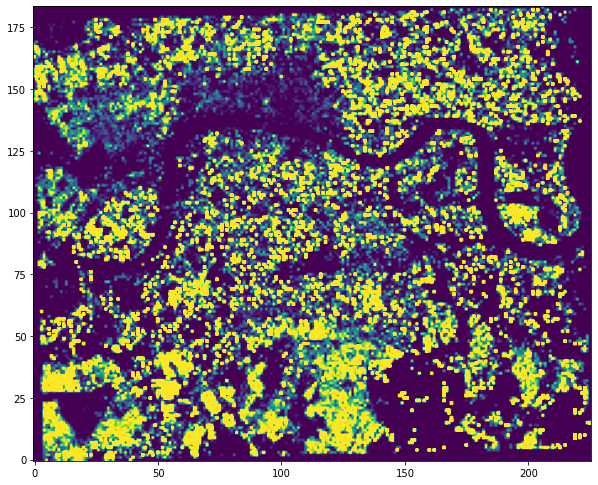

In [61]:
%%time
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(probs, origin='lower', vmax=20)  # change vmax to adjust contrast(stopping high density blowing out appearnce of low density)
del fig, ax

In [67]:
%%time
test = probs.copy()
test[~create_circular_mask(h=y_len, w=x_len)] = 0

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 582 µs


CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 15.6 ms


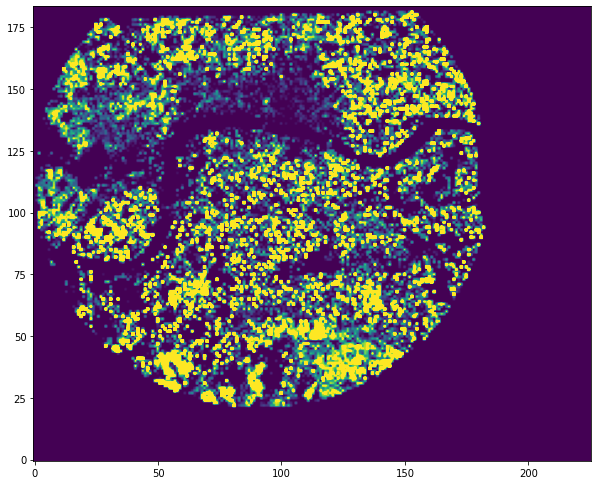

In [68]:
%%time
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(test, origin='lower', vmax=20)  # change vmax to adjust contrast(stopping high density blowing out appearnce of low density)
del fig, ax

In [ ]:
%%time


In [ ]:
# households within 60k
# generate a probability heatmap
# ravel and sample it
# if there are no free slots set it to 0
# if 100 misses in a row, regenerate probability map

In [ ]:
# pick a random vector
# query-ball around that vector
# try X vectors, then new dist

In [ ]:
%%time
batch_size = 300 # change dependent on RAM constraints
workplace_tree = all_households_within_60k = all_households_within_20k = all_households_within_5k = None

for index, workplace in enumerate(trimmed_work.itertuples()):
    if index >= 1_000:
        break
    if index % batch_size == 0:
        batch = index // batch_size
        workplace_tree = cKDTree(data=workplace_positions[(batch*batch_size):((batch+1)*batch_size)])
        all_households_within_60k = workplace_tree.query_ball_tree(households_kd_tree, 60_000)
        all_households_within_20k = workplace_tree.query_ball_tree(households_kd_tree, 20_000)
        all_households_within_5k = workplace_tree.query_ball_tree(households_kd_tree, 5_000)
    # workplace_row.capacity
    # workplace.index
    location = (workplace.geometry.x, workplace.geometry.y)
    

del workplace_tree, all_households_within_60k, all_households_within_20k, all_households_within_5k

In [ ]:
%%time
fp = pyrosm.get_data("London", update=True)
# Get the shapely geometry from GeoDataFrame
bbox_geom = boundary['geometry'].values[0]

# Initialise with bounding box
osm = pyrosm.OSM(fp, bounding_box=bbox_geom)

In [ ]:
%%time
walk_net = osm.get_network(network_type="walking")
bike_net = osm.get_network(network_type="cycling")
drive_net = osm.get_network(network_type="driving+service")

In [ ]:
%%time
walk_net.plot()
bike_net.plot()
drive_net.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
walk_net.plot(ax=ax, linewidth=0.3)
clipped_nodes.plot(ax=ax, markersize=1, color="red")
clipped_new_edges[~clipped_new_edges.is_empty].plot(ax=ax, linewidth=0.1, color="red")

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def _get_commute_dist():
    mean = 30.0
    std_dev = 7.0
    size = 100_000
    distances = np.random.normal(mean, std_dev, size)  # TODO Update this to reflect actual distribution from research
    distance_iter = iter(distances)
    
    while True:
        if next(distance_iter, None) is None:
            distances = np.random.normal(mean, std_dev, size)  # refresh the distances
            distance_iter = iter(distances)
        yield next(distance_iter)

In [ ]:
commute_dist_gen = _get_commute_dist()
distances = list()
for i in range(20):
    distances.append(next(commute_dist_gen))